# Minionology: HVSR with seismic nodes
### Skience2023 practical on HVSR, node installation, applications, Geopsy, continuous data analysis

# Continuous HV processing

##### Authors:
* Koen Van Noten ([@KoenVanNoten](https://github.com/KoenVanNoten))
* Martin Zeckra ([@marzeck](https://github.com/marzeck))

##### Introduction:
In the previous exercises, we had to do the HVSR data analysis manually in Geopsy. HV processing can also be done in an automatic way calling Geopsy from command lines. In this notebook we explain how to use Geopsy's HV module from the Linux terminal (bash scripting) or from windows and how to run the calculations without a GUI. This will help to prepare the processing of longer recording times, as the amount of waveform data that can be handled in Geopsy at once is rather limited. 

##### Prerequirements:
- geopsy (https://www.geopsy.org/): tested with geopsypack-win64-3.4.2

All the command line information can be found here: https://www.geopsy.org/wiki/index.php/Geopsy:_Waveform_Command_Line

For the continuous processing of the data you have two options: 

1.) run the first script and load the default geopsy parameter files

2.) Create with the bash operation an empty parameter file (i.e. geopsy-hv.params), adapt it to your needs and run everything in the terminal.

In [4]:
import os
import glob
from obspy import read
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

# run the HVSR Minionology function notebook
%run 00_HVSR_Minionology_definitions.ipynb

# use ipython notebook in a wider screen
from IPython.display import display, HTML # Widen the view
#display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Script to load waveforms and default geopsy parameter analysis
In Linux it is enough to load Geopsy using the !geopsy-hv command. 

In Windows10 the specific user path to the geopsy.exe file needs to be given.

#### Commands:
Geopsy command lines can be called by the help function: -help

In [ ]:
# Linux
#geopsy-hv.exe -help

# Windows
!C:/Users/koenvn/geopsypack-win64-3.4.2/bin/geopsy-hv.exe -help

We will first play with one node example to understand automation. Let's start with the first node of the Brussels case of exercise 1:

Miniseed file: __"HVSR_ex1_Bru\Raw_Data\453000039.1.2022.12.02.09.20.00.000.*.miniseed"__

First:
* Analyse the data in Geopsy: 120s, no trigger, 50% overlap, 40% smoothing and save in __HVSR_ex2_Auto\Analysed__

Then:
* call __geopsy.exe__
* call the __-hv module__ followed by the __miniseed file__
* call the .log file created above by __-param HVSR_ex2_Auto\Analysed\BE_00039.log__
* store the generated .hv file in a new folder by __-o HVSR_ex2_Auto\Auto_Analysed__

In [ ]:
### For Linux users
#!geopsy-hv -hv -param-example HVSR_ex1_Bru\Raw_Data\453000039.1.2022.12.02.09.20.00.000.*.miniseed > geopsy-hv.params

### Windows 10 - give the location where geopsy.exe is stored
### usually in !C:/Users/<USER>/geopsypack-win64-3.4.2/bin/geopsy
!C:/Users/koenvn/geopsypack-win64-3.4.2/bin/geopsy-hv.exe -hv "HVSR_ex1_Bru\Raw_Data\453000039.1.2022.12.02.09.20.00.000.*.miniseed" -param "HVSR_ex2_Auto\Analysed\BE_00039.log" -o "HVSR_ex2_Auto\Auto_Analysed"

Let's compare the GUI .hv (in Analysed) and the command line .hv (in Auto_analysed)

In [ ]:
# create the HV plot
fig, ax= plt.subplots(figsize=(10,5))
    
#### read and plot the manual HV example file
in_file = r'HVSR_ex2_Auto\Analysed\BE_00039.hv'

Freq, A, A_min, A_max = read_HV(in_file) # Get the HV profile
f0_curve, A0_curve, A0_min_curve, A0_max_curve = get_params_from_HV_curve(in_file) # Get the HV params from the HV plot
plot_HV(Freq, A, A_min, A_max, f0_curve, A0_curve, A0_min_curve, A0_max_curve, 'Manual', 'Blue') #plot the curve
get_Brussels_powerlaw(f0_curve) # print the bedrock depth

#### read and plot the auto HV example file
auto_file = r'HVSR_ex2_Auto\Auto_Analysed\BE_00039.hv'

Freq, A, A_min, A_max = read_HV(auto_file) # Get the HV profile
f0_curve, A0_curve, A0_min_curve, A0_max_curve = get_params_from_HV_curve(auto_file) # Get the HV params from the HV plot
plot_HV(Freq, A, A_min, A_max, f0_curve, A0_curve, A0_min_curve, A0_max_curve, 'Automatic', 'Red') #plot the curve
get_Brussels_powerlaw(f0_curve) # print the bedrock depth

# Params
ax.set_yscale('log')
plt.xlabel('H/V amplitude', fontsize = 14)
plt.ylabel('Frequency ([Hz])', fontsize = 14)
plt.legend()
plt.title(os.path.splitext(os.path.split(in_file)[1])[0], fontsize = 14)
plt.grid(ls='--')

__Are you happy with his curve?__ 
No. Why not? Because all windows were accepted in the automatic solution. 

Now try to do the same exercise by using a __Relative Treshold of 70%__, Reject time windows and clear the grayed curved (see exercise 1). Save this log and .hv file and compare again with the automatic solution. 

The question now is how to force the automatic solution so that is resembles the manual solution. In Geopsy, you can use the Frequency Rejection of Cox et al. (2020) to autoreject the bad windows. Play with the params to get the HV curve simiar to the manual solution, e.g.:
* min. freq.: 0.50 Hz
* max. freq.: 50 Hz
* stdv v: 2.50
* nr iterations: 500

More information on this auto rejection is explained here by B. Cox: _As you may recall from my 2020 paper, __n is the number of standard deviations__. So, when using n = 2 we are incorporating approximately 95% of the f0 values obtained from the various time windows. When using n = 1 we are incorporating only about 68% of the f0 values from the various time windows. The choice of n depends on how noisy the site is. If the site is very noisy, there will be a lot of near-receiver noise sources that are imparting energy to the sensor that is not traveling upward through the ground. These contaminated time windows need to be rejected. In this case, one would need to set n lower to reject more of the contaminated windows. However, setting n too low will result in good windows being rejected, which will bias your f0 sigma values to low estimates. The median value of f0 may or may not be affected very much, but the sigma of f0 will definitely be affected. I typically start by using n = 2 and then decrease n if it looks like I am still not getting rid of some of the outlying f0 values. This is subjective, but I feel it is a good way to do it. __The STA / LTA anti-triggering is doing something completely different__. It is simply looking at which time windows have relatively high amplitudes and rejecting them. This is based on the premise that near-receiver sources of energy will have high amplitudes. In many cases they do. But not always. I found that the STA / LTA method was difficult to use and could not produce results that were statistically based. That’s why I developed the FWA approach._ : https://www.geopsy.org/forum/viewtopic.php?t=535

## 2. Create a parameter file to your needs and run Geopsy from command

Now we will try a more automated way. In this script, the HV .log file is first loaded by default parameters. Then, we will update those parameters depending on the personal needs/dataset. 

In [17]:
## We create a default PARAM multiline string with the static components for whole processing 
## and formatters for variables
paramsString = '''\
PARAMETERS_VERSION=1    
FROM_TIME_TYPE=Absolute
FROM_TIME_TEXT={tStart}
TO_TIME_TYPE=Absolute
TO_TIME_TEXT={tEnd}
REFERENCE=
COMMON_TIME_WINDOWS=false
WINDOW_LENGTH_TYPE=Exactly
WINDOW_MIN_LENGTH(s)={winLen}
WINDOW_MAX_LENGTH(s)={winLen}
WINDOW_MAX_COUNT=0
WINDOW_MAXIMUM_PRIME_FACTOR=11
BAD_SAMPLE_TOLERANCE (s)=0
BAD_SAMPLE_GAP (s)=0
WINDOW_OVERLAP (%)={overlap}
BAD_SAMPLE_THRESHOLD_TYPE={threshold}
BAD_SAMPLE_THRESHOLD_VALUE (%)={threshold_pct}
ANTI-TRIGGERING_ON_RAW_SIGNAL (y/n)=n
ANTI-TRIGGERING_ON_FILTERED_SIGNAL (y/n)=n
SEISMIC_EVENT_TRIGGER (y/n)=n
SEISMIC_EVENT_DELAY (s)=-0.1
WINDOW_TYPE=Tukey
WINDOW_REVERSED=n
WINDOW_ALPHA=0.1
SMOOTHING_METHOD=Function
SMOOTHING_WIDTH_TYPE=Log
SMOOTHING_WIDTH={KO}
SMOOTHING_SCALE_TYPE=Log
SMOOTHING_WINDOW_TYPE=KonnoOhmachi
SMOOTHING_WINDOW_REVERSED=n
MINIMUM_FREQUENCY={minFreq}
MAXIMUM_FREQUENCY={maxFreq}
SCALE_TYPE_FREQUENCY=Log
STEP_TYPE_FREQUENCY=Count
SAMPLES_NUMBER_FREQUENCY=500
#STEP_FREQUENCY=1.00231
HIGH_PASS_FREQUENCY=0
HORIZONTAL_COMPONENTS={horizontals}
HORIZONTAL_AZIMUTH={azimuth}
ROTATION_STEP={rotSteps}
FREQUENCY_WINDOW_REJECTION_MINIMUM_FREQUENCY={rej_min_freq}
FREQUENCY_WINDOW_REJECTION_MAXIMUM_FREQUENCY={rej_max_freq}
FREQUENCY_WINDOW_REJECTION_STDDEV_FACTOR={rej_stdev}
FREQUENCY_WINDOW_REJECTION_MAXIMUM_ITERATIONS={rej_it}
'''
paramsString

'PARAMETERS_VERSION=1    \nFROM_TIME_TYPE=Absolute\nFROM_TIME_TEXT={tStart}\nTO_TIME_TYPE=Absolute\nTO_TIME_TEXT={tEnd}\nREFERENCE=\nCOMMON_TIME_WINDOWS=false\nWINDOW_LENGTH_TYPE=Exactly\nWINDOW_MIN_LENGTH(s)={winLen}\nWINDOW_MAX_LENGTH(s)={winLen}\nWINDOW_MAX_COUNT=0\nWINDOW_MAXIMUM_PRIME_FACTOR=11\nBAD_SAMPLE_TOLERANCE (s)=0\nBAD_SAMPLE_GAP (s)=0\nWINDOW_OVERLAP (%)={overlap}\nBAD_SAMPLE_THRESHOLD_TYPE={threshold}\nBAD_SAMPLE_THRESHOLD_VALUE (%)={threshold_pct}\nANTI-TRIGGERING_ON_RAW_SIGNAL (y/n)=n\nANTI-TRIGGERING_ON_FILTERED_SIGNAL (y/n)=n\nSEISMIC_EVENT_TRIGGER (y/n)=n\nSEISMIC_EVENT_DELAY (s)=-0.1\nWINDOW_TYPE=Tukey\nWINDOW_REVERSED=n\nWINDOW_ALPHA=0.1\nSMOOTHING_METHOD=Function\nSMOOTHING_WIDTH_TYPE=Log\nSMOOTHING_WIDTH={KO}\nSMOOTHING_SCALE_TYPE=Log\nSMOOTHING_WINDOW_TYPE=KonnoOhmachi\nSMOOTHING_WINDOW_REVERSED=n\nMINIMUM_FREQUENCY={minFreq}\nMAXIMUM_FREQUENCY={maxFreq}\nSCALE_TYPE_FREQUENCY=Log\nSTEP_TYPE_FREQUENCY=Count\nSAMPLES_NUMBER_FREQUENCY=500\n#STEP_FREQUENCY=1.00231\

Or load the paramString from the Function

In [6]:
paramsString = get_paramString()
paramsString

'PARAMETERS_VERSION=1    \nFROM_TIME_TYPE=Absolute\nFROM_TIME_TEXT={tStart}\nTO_TIME_TYPE=Absolute\nTO_TIME_TEXT={tEnd}\nREFERENCE=\nCOMMON_TIME_WINDOWS=false\nWINDOW_LENGTH_TYPE=Exactly\nWINDOW_MIN_LENGTH(s)={winLen}\nWINDOW_MAX_LENGTH(s)={winLen}\nWINDOW_MAX_COUNT=0\nWINDOW_MAXIMUM_PRIME_FACTOR=11\nBAD_SAMPLE_TOLERANCE (s)=0\nBAD_SAMPLE_GAP (s)=0\nWINDOW_OVERLAP (%)={overlap}\nBAD_SAMPLE_THRESHOLD_TYPE={threshold}\nBAD_SAMPLE_THRESHOLD_VALUE (%)={threshold_pct}\nANTI-TRIGGERING_ON_RAW_SIGNAL (y/n)=n\nANTI-TRIGGERING_ON_FILTERED_SIGNAL (y/n)=n\nSEISMIC_EVENT_TRIGGER (y/n)=n\nSEISMIC_EVENT_DELAY (s)=-0.1\nWINDOW_TYPE=Tukey\nWINDOW_REVERSED=n\nWINDOW_ALPHA=0.1\nSMOOTHING_METHOD=Function\nSMOOTHING_WIDTH_TYPE=Log\nSMOOTHING_WIDTH={KO}\nSMOOTHING_SCALE_TYPE=Log\nSMOOTHING_WINDOW_TYPE=KonnoOhmachi\nSMOOTHING_WINDOW_REVERSED=n\nMINIMUM_FREQUENCY={minFreq}\nMAXIMUM_FREQUENCY={maxFreq}\nSCALE_TYPE_FREQUENCY=Log\nSTEP_TYPE_FREQUENCY=Count\nSAMPLES_NUMBER_FREQUENCY=500\n#STEP_FREQUENCY=1.00231\

There are several params that are variable. We adapt the PARAMS for the whole dataset we want to analyse. 

In [7]:
# overall processing lengths (time for which we compute the total HV-curve)
process_len = 3600. # [s] standard 1 hour
#process_len = 1800. # [s] standard 0.5 hour

# window length for each HV curve
time_window_len = 60. # [s] standard 60 or 120s

#overlapping windows
win_overlap = 50

# threshold and percentage
threshold = 'RelativeSampleThreshold'
threshold_pct = 0.7

#Smoothing (in digits)
KO = 0.4

# lower frequency bound
min_freq = 0.5 # [Hz]

# upper frequency bound
max_freq = 50 # [Hz]

# how to calculate horizontals (Squared, Energy, Azimuth, Geometric)
horizontals_method = 'Squared' # standard 'Squared'

# if 'Azimuth is given'
azimuth = 0

# in case you want run the HV rotate module (see exercise 4)
want_rotation = True # True, False
rotation_steps = 10 # [degree]

# Using the Cox et al. 2020 filtering 
#FREQUENCY_WINDOW_REJECTION_MINIMUM_FREQUENCY
rej_min_freq = 0.5
#FREQUENCY_WINDOW_REJECTION_MAXIMUM_FREQUENCY
rej_max_freq = 50
#FREQUENCY_WINDOW_REJECTION_STDDEV_FACTOR
rej_stdev = 1.8
#FREQUENCY_WINDOW_REJECTION_MAXIMUM_ITERATIONS
rej_it = 500

Now the parameters are given, it is time to fill in these parameters in the PARAM file. We will use Obspy for getting the begin and endtime from the seismic data. This can easily be done by reading tr.stats.   

In [8]:
#finally some seismology and Obspy

from obspy import read
from obspy.core.trace import Stats

#wf = r'HVSR_ex1_Br\\Raw_Data\\453000039.1.2022.12.02.09.20.00.000.*.miniseed'
#wf = r'HVSR_ex1_Br\\Raw_Data\\453000039.1.2022.12.02.09.20.00.000.*.miniseed'

st = read(r'HVSR_ex1_Bru\\Raw_Data\\453000039.1.2022.12.02.09.20.00.000.*.miniseed')
#st = read(wf)

tr = st[0]
time = tr.stats.starttime
tStart = '%s%02d%02d%02d%02d%#05.2f'%(time.year, time.month, time.day, time.hour, time.minute, time.second)
endtime = tr.stats.endtime
tEnd = '%s%02d%02d%02d%02d%#05.2f'%(endtime.year, endtime.month, endtime.day, endtime.hour, endtime.minute, endtime.second)

# adapt an auto-PARAM file with the given parameters so that for each processing loop the same param is used
with open('geopsy-hv-auto.params', 'w') as f:
            f.write(paramsString.format(
                # Select start and end time from waveform
                tStart=tStart,
                # Select end time from waveform
                tEnd=tEnd,
                # Adapt the parameters of previously chosen parameters 
                threshold=threshold,
                threshold_pct=threshold_pct,
                KO=KO,
                winLen=time_window_len,
                overlap=win_overlap,
                minFreq=min_freq,
                maxFreq=max_freq,
                horizontals=horizontals_method,
                azimuth=azimuth,
                rotSteps=rotation_steps,
                rej_min_freq=rej_min_freq, 
                rej_max_freq=rej_max_freq, 
                rej_stdev=rej_stdev,
                rej_it = rej_it
                ))

Now the param is changed and loaded as _geopsy-hv-auto.params_ file, launch Geopsy again but now with the -param geopsy-hv-auto.params parameter (and not by a .log file as in the previous example) 

In [34]:
### Windows 10 - give the location where geopsy.exe is stored
### usually in !C:/Users/<USER>/geopsypack-win64-3.4.2/bin/geopsy
!C:/Users/koenvn/geopsypack-win64-3.4.2/bin/geopsy-hv.exe -hv "HVSR_ex1_Bru\Raw_Data\453000039.1.2022.12.02.09.20.00.000.*.miniseed" -param geopsy-hv-auto.params -o "HVSR_ex2_Auto\Auto_Analysed"

geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453000039.1.2022.12.02.09.20.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453000039.1.2022.12.02.09.20.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453000039.1.2022.12.02.09.20.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_00039 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_00039 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_00039 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

Let's compare again the manual .hv (Geopsy) with the automatic .hv file (from command with predefined user params)

Manual: At 0.94 Hz (f0), the maximum H/V amplitude is 8.9 ± 2.5
    Bedrock at 98.79 m depth
Automatic: At 0.94 Hz (f0), the maximum H/V amplitude is 7.9 ± 4.4
    Bedrock at 98.79 m depth


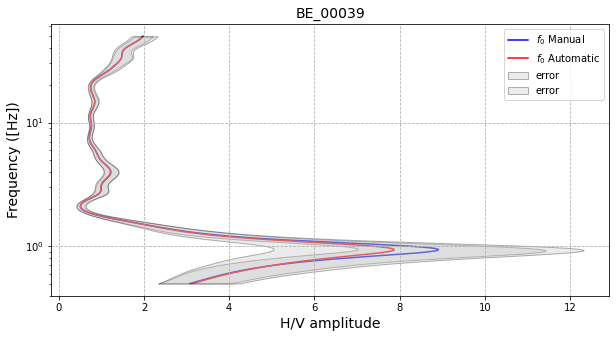

In [35]:
# create the HV plot
fig, ax= plt.subplots(figsize=(10,5))
    
#### read and plot the manual HV example file
in_file = r'HVSR_ex2_Auto\Analysed\BE_00039.hv'

Freq, A, A_min, A_max = read_HV(in_file) # Get the HV profile
f0_curve, A0_curve, A0_min_curve, A0_max_curve = get_params_from_HV_curve(in_file) # Get the HV params from the HV plot
plot_HV(Freq, A, A_min, A_max, f0_curve, A0_curve, A0_min_curve, A0_max_curve, 'Manual', 'Blue') #plot the curve
get_Brussels_powerlaw(f0_curve) # print the bedrock depth

#### read and plot the auto HV example file
auto_file = r'HVSR_ex2_Auto\Auto_Analysed\BE_00039.hv'

Freq, A, A_min, A_max = read_HV(auto_file) # Get the HV profile
f0_curve, A0_curve, A0_min_curve, A0_max_curve = get_params_from_HV_curve(auto_file) # Get the HV params from the HV plot
plot_HV(Freq, A, A_min, A_max, f0_curve, A0_curve, A0_min_curve, A0_max_curve, 'Automatic', 'Red') #plot the curve

get_Brussels_powerlaw(f0_curve) # print the bedrock depth

# Params
ax.set_yscale('log')
plt.xlabel('H/V amplitude', fontsize = 14)
plt.ylabel('Frequency ([Hz])', fontsize = 14)
plt.legend()
plt.title(os.path.splitext(os.path.split(in_file)[1])[0], fontsize = 14)
plt.grid(ls='--')

* __Evaluate__ the result. 
* Is there still a difference between the manual and auto solution? 
* Which is the difference? 
* Evaluate the difference in the shape of the curve, the f0 and HV amplitude values.

## 3. Loop over a waveform datafolder for HVSR batch processing
Now we understand how to call Geopsy from the command line, last step is develop a code that can loop over:
* __3.1.__ a set of waveforms and autoprocess the HVSR of each waveform. This exercise is interesting to autoprocess many datarecordings.  
* __3.2.__ one waveform with multiple hours or days of data and autoprocess each hour/day of data

3.1 is interesting to autoprocess many datarecordings but 3.2. is particularly interesting as the variability of the H/V curve can be investigated over time, with changing weather/noise conditions.

### 3.1. Loop over a folder with waveforms and autoprocess the HV-curve
As you understand now the processing as explained in point 2, I'll let you play with the commands yourself. Try to create a param file (or use the one in section 2) and autoprocess the example files in folder __HVSR_ex1_Bru\Raw_Data__

In [ ]:
# create the param file, or use the param file of above

In [ ]:
# loop over a waveform folder using glob.glob
# select the waveforms (E, N, Z) 
# execute the geopsy command line
# save the resulting .hv file in a dedicated folder

### 3.2. Loop over one waveform, split the data in hourly chunks and autoprocess the HV-curve
This exercise is more tricky as we need to run over different overlapping tStart and tEnd times, adapt the PARAM file (ParamsString) and run Geopsy for each (half)hour (or day, or whatever timing you want) of data. We will play with node 0617 ("453000617.1.2022.12.02.08.49.00.000.*.miniseed"), which was the node recording the longest in Brussels.

In [19]:
# overall processing lengths (time for which we compute the total HV-curve)
#process_len = 3600. # [s] standard 1 hour
process_len = 1800. # [s] standard 1 hour

# window length for each HV curve
time_window_len = 60. # [s] standard 60 or 120s

#overlapping windows
win_overlap = 50

# threshold and percentage
threshold = 'RelativeSampleThreshold'
threshold_pct = 0.7

#Smoothing (in digits)
KO = 0.4

# lower frequency bound
min_freq = 0.5 # [Hz]

# upper frequency bound
max_freq = 50 # [Hz]

# how to calculate horizontals (Squared, Energy, Azimuth, Geometric)
horizontals_method = 'Squared' # standard 'Squared'

# if 'Azimuth is given'
azimuth = 0

# in case you want run the HV rotate module (see exercise 4)
want_rotation = True # True, False
rotation_steps = 10 # [degree]

# Using the Cox et al. 2020 filtering 
#FREQUENCY_WINDOW_REJECTION_MINIMUM_FREQUENCY
rej_min_freq = 0.5
#FREQUENCY_WINDOW_REJECTION_MAXIMUM_FREQUENCY
rej_max_freq = 50
#FREQUENCY_WINDOW_REJECTION_STDDEV_FACTOR
rej_stdev = 1.8
#FREQUENCY_WINDOW_REJECTION_MAXIMUM_ITERATIONS
rej_it = 500

In [20]:
# Give waveform
#wf = "HVSR_ex1_Bru\\Raw_Data\\453000617.1.2022.12.02.08.49.00.000.*.miniseed"
wf = "HVSR_ex1_Bru\\Raw_Data\\453001013.1.2022.12.02.09.04.00.000.*.miniseed"
node_ID = os.path.split(wf)[-1].split('.')[0] # Better to have BE.00617 in the folder name or the full node ID name??
print(node_ID)

# Give outputfolder where to save the .hv files
output_folder = 'HVSR_ex2_Auto/Auto_Analysed/'

453001013


In [21]:
## Get the station info
st = read(wf)
tr = st[0]
start = tr.stats.starttime
end = tr.stats.endtime
station = '%s_%s'%(tr.stats.network, tr.stats.station)
print('station: %s'%station)

delta = end-start
print("start: %s"%start)
print("end: %s"%end) 
print("We will get %s .hv files of %ss length out of the stream"%(int(delta/process_len), process_len))

for i in np.arange(start, end, process_len):
        time = i
        print(time)
        tStart = '%s%02d%02d%02d%02d%#05.2f'%(time.year, time.month, time.day, time.hour, time.minute, time.second)
        tStart_hv = '%s%02d%02d%02d%02d%#02d'%(time.year, time.month, time.day, time.hour, time.minute, time.second)
        endtime = time + process_len
        tEnd = '%s%02d%02d%02d%02d%#05.2f'%(endtime.year, endtime.month, endtime.day, endtime.hour, endtime.minute, endtime.second)
        
        # get the empty auto-paramString
        paramsString = get_paramString()
        
        # adapt an auto-PARAM file with the given parameters so that for each processing loop the same param is used
        with open('geopsy-hv-auto.params', 'w') as f:
            f.write(paramsString.format(
                # Select start and end time from waveform
                tStart=tStart,
                # Select end time from waveform
                tEnd=tEnd,
                # Adapt the parameters of previously chosen parameters 
                threshold=threshold,
                threshold_pct=threshold_pct,
                KO=KO,
                winLen=time_window_len,
                overlap=win_overlap,
                minFreq=min_freq,
                maxFreq=max_freq,
                horizontals=horizontals_method,
                azimuth=azimuth,
                rotSteps=rotation_steps,
                rej_min_freq=rej_min_freq, 
                rej_max_freq=rej_max_freq, 
                rej_stdev=rej_stdev,
                rej_it = rej_it
                ))
        
        ### Make a folder for each station output
        os.makedirs(output_folder+node_ID, exist_ok=True)
        out_folder = ''.join(output_folder+node_ID)
        
        ### Run geopsy for each step in the loop
        !C:/Users/koenvn/geopsypack-win64-3.4.2/bin/geopsy-hv.exe -hv {''.join(wf)} -param geopsy-hv-auto.params -o {''.join(output_folder+node_ID)}
        
        ### Rename the .hv output file and the .log to save a unique files for each processed process_len
        ### saving the .log files is useful as these can be loaded in Geopsy to manually check the processed data 
        os.renames(os.path.join(output_folder, '{0}/{1}.hv'.format(node_ID, station)), os.path.join(output_folder, '{0}/{1}.{2}.hv'.format(node_ID, station, tStart_hv)))
        os.renames(os.path.join(output_folder, '{0}/{1}.log'.format(node_ID, station)), os.path.join(output_folder, '{0}/{1}.{2}.log'.format(node_ID, station, tStart_hv)))

        # if want_rotation is selected, also the HV rotate module will be executed and stored in the outfolder  
        if want_rotation:
            
            # run the geopsy rotation
            !C:/Users/koenvn/geopsypack-win64-3.4.2/bin/geopsy-hv.exe -rotate {''.join(wf)} -param geopsy-hv-auto.params -o {''.join(output_folder+node_ID)}
            
            ### Rename the .hv.grid output file
            os.renames(os.path.join(output_folder, '{0}/{1}.hv'.format(node_ID, station)), os.path.join(output_folder, '{0}/{1}.{2}.grid'.format(node_ID, station, tStart_hv)))
            
        print('**********************************')    

print('Job Done')

station: BE_01013
start: 2022-12-02T09:04:00.000000Z
end: 2022-12-02T14:15:59.990000Z
We will get 10 .hv files of 1800.0s length out of the stream
2022-12-02T09:04:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
2022-12-02T09:34:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
2022-12-02T10:04:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
2022-12-02T10:34:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
2022-12-02T11:04:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
2022-12-02T11:34:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
2022-12-02T12:04:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

geopsy-hv:   task index 0: processed during 0.508 s
geopsy-hv:   task index 0: processed during 0.529 s
geopsy-hv:   task index 0: processed during 0.542 s
geopsy-hv:   task index 0: processed during 0.556 s
geopsy-hv:   task index 0: processed during 0.56 s
geopsy-hv:   task index 0: processed during 0.576 s
geopsy-hv:   task index 0: processed during 0.578 s
geopsy-hv: Get statistics...
geopsy-hv: 
geopsy-hv: Process ended at 2023-02-22 00:19:35
geopsy-hv: Process run in 00:00:01
geopsy-hv: Saving to 'C:/OMA/Courses/20230227 SKIENCE/HVSR_ex2_Auto/Auto_Analysed/453001013'...


**********************************
2022-12-02T12:34:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
2022-12-02T13:04:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

geopsy-hv:   task index 0: processed during 0.638 s
geopsy-hv:   task index 0: processed during 0.641 s
geopsy-hv: Get statistics...
geopsy-hv: 
geopsy-hv: Process ended at 2023-02-22 00:19:58
geopsy-hv: Process run in 00:00:01
geopsy-hv: Saving to 'C:/OMA/Courses/20230227 SKIENCE/HVSR_ex2_Auto/Auto_Analysed/453001013'...


**********************************
2022-12-02T13:34:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

geopsy-hv:  [PARAM] 
geopsy-hv: Process started at 2023-02-22 00:20:09
geopsy-hv: BE_01013: 52 windows
geopsy-hv:   task index 0: processed during 0.501 s
geopsy-hv:   task index 0: processed during 0.508 s
geopsy-hv:   task index 0: processed during 0.518 s
geopsy-hv:   task index 0: processed during 0.551 s
geopsy-hv:   task index 0: processed during 0.554 s
geopsy-hv:   task index 0: processed during 0.554 s
geopsy-hv:   task index 0: processed during 0.564 s
geopsy-hv:   task index 0: processed during 0.574 s
geopsy-hv: Get statistics...
geopsy-hv: 
geopsy-hv: Process ended at 2023-02-22 00:20:10
geopsy-hv: Process run in 00:00:01
geopsy-hv: Saving to 'C:/OMA/Courses/20230227 SKIENCE/HVSR_ex2_Auto/Auto_Analysed/453001013'...


**********************************
2022-12-02T14:04:00.000000Z


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

**********************************
Job Done


geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.E.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.N.miniseed...
geopsy-hv: Loading C:/OMA/Courses/20230227 SKIENCE/HVSR_ex1_Bru/Raw_Data/453001013.1.2022.12.02.09.04.00.000.Z.miniseed...
geopsy-hv: Selected groups:
geopsy-hv: *********** All signals ***********
geopsy-hv: Add signal id 3 to component Vertical of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 2 to component North of station BE_01013 at 0.00 0.00 0.00
geopsy-hv: Add signal id 1 to component East of station BE_01013 at 0.00 0.00 0.00
geopsy-hv:  [PARAM] # Version 0: all files generated with releases before 20170901 (default for input)
geopsy-hv:  [PARAM] PARAMETERS_VERSION=1
geopsy-hv:  [PARAM] # TYPEs:
geopsy-hv:  [PARAM] #   - Signal: from the start or to the end of signal (TEXT are useless)
geopsy-hv:  [PARAM] #   - Delta: a fi

## 4. Visualising auto results
The final step consists of visualing the auto-generated .hv files with time. Try to plot the .hv results from each node through time. Loop over the .hv files with glob.glob and read in the data.   

HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202084900.hv 2022-12-02 08:49:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202091900.hv 2022-12-02 09:19:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202094900.hv 2022-12-02 09:49:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202101900.hv 2022-12-02 10:19:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202104900.hv 2022-12-02 10:49:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202111900.hv 2022-12-02 11:19:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202114900.hv 2022-12-02 11:49:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202121900.hv 2022-12-02 12:19:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202124900.hv 2022-12-02 12:49:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202131900.hv 2022-12-02 13:19:00
HVSR_ex2_Auto/Auto_Analysed\453000617\BE_00617.20221202134900.hv 2022-12-02 13:49:00
HVSR_ex2_Auto/Auto_Analysed\453001013\BE_01013.20221202090400.hv 

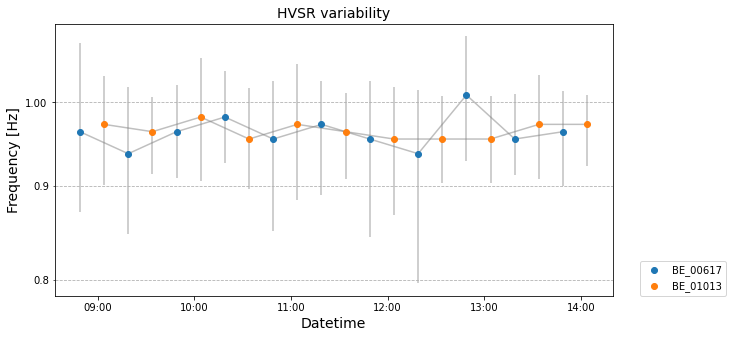

In [22]:
# give the output folder containing all subfolders with continuous hv files
output_folder = 'HVSR_ex2_Auto/Auto_Analysed/'

###################################################################""
# create the continuous HV plot
fig, ax1= plt.subplots(figsize=(10,5))

# loop over the subfolders
folders = glob.glob("%s/*/"%output_folder, recursive = True)
for i in folders:
    
    f0_wins = []
    f0_avgs = []
    A0s = []
    times = []
    errors_min, errors_max = [], []
    HV_files = glob.glob('%s/*.hv'%i)
    # loop over the HV files
    for i in HV_files:
        node_ID = os.path.split(i)[-1].split('.')[0]
        # read the time from the HV name
        time = os.path.split(i)[1].split('.')[1]
        year = time[0:4]
        d = datetime.datetime(int(time[0:4]),int(time[4:6]), int(time[6:8]), int(time[8:10]), int(time[10:12]), int(time[12:14]))
        print(i, d)

        f0_avg, f0_win, error, A0, nw_avg, nw_win, f_min, f_max = get_params_from_HV(i)

        f0_avgs.append(f0_avg)
        A0s.append(A0)
        f0_wins.append(f0_win)
        errors_min.append(f0_avg-f_min)
        errors_max.append(f_max-f0_avg)
        times.append(d)

    plt.scatter(times, f0_avgs, ls='-', label = node_ID)    
    plt.errorbar(times, f0_avgs, xerr=None, yerr = (errors_min, errors_max), c='grey',  alpha=0.5, zorder=-1)   
    ax1.set_yscale('log')
    ax1.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax1.yaxis.set_major_formatter(mticker.ScalarFormatter())
    ax1.set_xlabel('Datetime', fontsize = 14)
    ax1.set_ylabel('Frequency [Hz]', fontsize = 14)
    ax1.legend(bbox_to_anchor=(1.05, 0), loc="lower left", borderaxespad=0, ncol=1)
    ax1.grid(ls='--', axis='y', which='both')
    plt.subplots_adjust(hspace=0.1)
    ax1.tick_params(labelbottom=True)
    plt.title('HVSR variability', fontsize = 14)

    #Format the xaxis date
    from matplotlib.dates import DateFormatter, DayLocator, HourLocator

    ax1.xaxis.set_major_locator(HourLocator())
    ax1.xaxis.set_major_formatter(DateFormatter("%H:%M"))
plt.show()